In [4]:
import warnings
import numpy as np
import matplotlib.pyplot as plt
from numpy.random import default_rng
import itertools as it
import sys
import progressbar
import time
import random

from scipy import linalg
from scipy.linalg import LinAlgWarning

import pickle

warnings.filterwarnings(action='error', category=LinAlgWarning, module='sklearn')

from joblib import Parallel, delayed
import os
cpuCount = os.cpu_count()


In [5]:

def create_G(k, rx, ry=0., rz=0., threshold = 1e-6):
     # threshold for normalization

    r_in = np.sqrt(rx**2 + ry**2 + rz**2) # input r
    r = r_in + threshold # renormalize to avoid divergences
    phase = np.exp(1j*k*r)/(4*np.pi*r)

    G = {"xx":0., "yy":0., "xy":0.}
    G["xx"] = phase * ( 1. + (1j*k*r-1.)/(k*r) + ( -1. + (3.-3.*1j*k*r)/(k*r)**2)*rx**2/r**2 ) 
    G["yy"] = phase * ( 1. + (1j*k*r-1.)/(k*r) + ( -1. + (3.-3.*1j*k*r)/(k*r)**2)*ry**2/r**2 )
    G["xy"] = phase * ( ( -1. + (3.-3.*1j*k*r)/(k*r)**2)*rx*ry/r**2 )

    for key in G.keys():
        G[key][r_in<threshold] = 0. # set vals with r=0. to zero (don't count emitter interacting with itself)

    return G

def create_G(k, rx, ry=0., rz=0., thres_same = 1e-12, thres_ren = 1e-6):

    r_in = np.sqrt(rx**2 + ry**2 + rz**2) # input r
    
    r = r_in
    r[ r_in<thres_ren ] = thres_ren # renormalize to avoid divergences
    
    phase = np.exp(1j*k*r)/(4*np.pi*r)

    G = dict()
    G["xx"] = phase * ( 1. + (1j*k*r-1.)/(k*r) + ( -1. + (3.-3.*1j*k*r)/(k*r)**2)*rx**2/r**2 ) 
    G["yy"] = phase * ( 1. + (1j*k*r-1.)/(k*r) + ( -1. + (3.-3.*1j*k*r)/(k*r)**2)*ry**2/r**2 )
    G["xy"] = phase * ( ( -1. + (3.-3.*1j*k*r)/(k*r)**2)*rx*ry/r**2 )

    
    for key in G.keys():
        G[key][r_in<threshold] = 0. # set vals with r=0. to zero (don't count emitter interacting with itself)
    return G

In [10]:
# for convention, x-axis is axis along which potential is and excitons are positioned (just 1D)

# evaluate the dyadic Green's function for (k,r). k is wavevector of incident beam (k=2*pi if units of lambda are used)
# r=|r1-r2| for two particles (r can be a matrix)

def create_G(k, rx, ry=0., rz=0., thres_same = 1e-12, thres_ren = 1e-12):
    
    r_in = np.sqrt(rx**2 + ry**2 + rz**2) # input r
    
    rx_ren = rx + thres_ren*np.random.random_sample(r_in.shape)    
    r = np.sqrt(rx_ren**2 + ry**2 + rz**2)  # add some random noise to renormalize for divergences

    
    phase = np.exp(1j*k*r)/(4*np.pi*r)

    G = dict()
    G["xx"] = phase * ( 1. + (1j*k*r-1.)/(k*r) + ( -1. + (3.-3.*1j*k*r)/(k*r)**2)*rx**2/r**2 ) 
    G["yy"] = phase * ( 1. + (1j*k*r-1.)/(k*r) + ( -1. + (3.-3.*1j*k*r)/(k*r)**2)*ry**2/r**2 )
    G["xy"] = phase * ( ( -1. + (3.-3.*1j*k*r)/(k*r)**2)*rx*ry/r**2 )
    
    
    for key in G.keys():
        G[key][r_in<thres_same] = 0. # set vals with r=0. to zero (don't count emitter interacting with itself)

    return G

def regularize_pos(v_x, min_dx=0.01):
    v_x = np.sort(v_x)
    L_x = v_x[-1]-v_x[0]
    
    diff_x = np.diff(v_x)
    tot_reg = np.sum(diff_x<min_dx)
    diff_reg = [np.maximum(dx, min_dx) for dx in diff_x]
    
    return np.cumsum([v_x[0]]+diff_reg)*L_x/(L_x + tot_reg*min_dx) # make sure it has the same length again



def create_A(x_ij,v_alpha, X=None):
    G = create_G(2.*np.pi, rx=x_ij)
    
    A = dict()
    A["xx"] = 4.*np.pi**2/epsilon*( G["xx"]@np.diag(v_alpha) )
    A["yy"] = 4.*np.pi**2/epsilon*( G["yy"]@np.diag(v_alpha) )
    A["xy"] = 4.*np.pi**2/epsilon*( G["xy"]@np.diag(v_alpha) )
    return A

# polarization of an emitter 
def alpha(delta, gamma, lambda_a=1., gamma_0=None):
    if gamma_0 is None:
        gamma_0 = gamma
    return -3./(4.*np.pi**2)*epsilon*lambda_a**3*(gamma/2.)/(delta+1j*gamma_0/2.)

def stack_xy(A):
      return np.block([[A["xx"], A["xy"]], 
                        [A["xy"], A["yy"]]])
    
def mean_reject_outliers(data, m=5.):
    return np.mean(data[abs(data - np.mean(data)) < m * np.std(data)])

def reject_outliers(data, m=5.):
    return data[abs(data - np.mean(data)) < m * np.std(data)]

# given a set of particles with polarizations v_p_x at positions v_x_exc, 
# reconstruct electric field for 2D array (v_x,v_z) at some y-offset (to avoid divergences)

def reconstruct_field_2D(v_x, v_y, v_x_exc, v_p, offset=0., plane_orientation = "xy"):
    N_exc = v_x_exc.size
    E_rec = {'x': np.zeros((v_x.size, v_y.size), dtype="complex"), 'y': np.zeros((v_x.size, v_y.size), dtype="complex") }
    for n, x_n in enumerate(list(v_x_exc)):
        X, Y = v_x[:,None]-x_n, v_y[None,:]
        if plane_orientation == "xy":
            G = create_G(2.*np.pi, rx=X, ry=Y, rz=offset)
        elif plane_orientation == "xz":
            G = create_G(2.*np.pi, rx=X, rz=Y, ry=offset)

    E_rec['x'] += 4.*np.pi**2/epsilon * ( G['xx']*v_p['x'][n] + G['xy']*v_p['y'][n])
    E_rec['y'] += 4.*np.pi**2/epsilon * ( G['yy']*v_p['y'][n] + G['xy']*v_p['x'][n]) 

    #if full_rec and plane_orientation=="xy":
    #  return np.exp(1j*2*np.pi*offset) + E_rec
    #elif full_rec and plane_orientation=="xz":
    #  return np.exp(1j*2*np.pi*v_y[None,:]) + E_rec
    #else:
    return E_rec


In [61]:
# variable parameters diagram
a_min, a_max, n_a = 0.12, .2, 5 # lattice distances in units of lambda
delta_min, delta_max, n_delta = -1., 1., 100 # delta in units of gamma

# lattice parameters

# randomness: 
# True: a potential well is randomly selected for each emitter and some disorder is added with variance D_a
# False: N_exc particles on a 1D array with lattice separation a (can be used for check)
rand_positions = True 

L = 2. # length of sample in terms wavelength
n = 5 # density
N_exc = int(L*n) # number of excitons

D_a = .05 # disorder on positions (Guassian fluctuations around minima potential) in units of a

if not rand_positions:
    L = N_exc

# system parameters
D_delta = 0.01 # disorder on resonances in units of delta (Gaussian standard deviation)
gamma = 1. # decay rate excitons, set as energy unit now
E = 1. # energy intensity incident light (uniform beam now, but that can be changed if e.g. spatial Gaussian profile would be necessary)
pol_angle = np.pi/2 # angle of polarization: 0. is along x-axis, where excitons are positioned, pi/2 is perpendicular to that

epsilon = 12.25 # dielectric constant GaAs (units of epsilon_0)
c = 1. # speed of light

N_sample = 64*256 # number of samples you want to use to average over for each point
parallel = True # use parallel

## Generate sample matrices (a, delta)

In [62]:
v_a = np.linspace(a_min, a_max, n_a)
v_delta = np.linspace(delta_min, delta_max, n_delta)

# function to create one instance of matrix (a, delta)
def create_a_delta_matrix(seed):
    
    rng = default_rng(seed + int(time.time()))
    
    pols = np.zeros((3,2,n_a,n_delta), dtype='complex') # first index is effective polarization, fully random or bare, second 'x' or 'y'
    for i_a, a in enumerate(list(v_a)):
        for i_delta, delta in enumerate(list(v_delta)):
            N_well = L/a
            # generate a random instance exc positions and delta's
            
            # random positions
            if rand_positions:
                v_x_exc = regularize_pos(
                    a*rng.integers(0,N_well, size=N_exc) + rng.normal( scale=D_a, size=N_exc) )
            else:
                v_x_exc = a*np.linspace(0.,N_exc-1.,N_exc)
            
            # just a sample of fully random positions in [0,L]
            v_x_exc_rand = regularize_pos( L*np.sort(rng.random((N_exc,))) )
            
            # random delta's
            v_delta_exc = delta + rng.normal( scale=D_delta, size=N_exc) 

            # create matrix (\alpha G)_ij 
            v_alpha = alpha(v_delta_exc, gamma) # polarization of emitters (with random delta for each one)
            x_ij = np.abs(v_x_exc[:,None] - v_x_exc[None,:]) # matrix of length differences |xi-xj|
            A = stack_xy(create_A(x_ij,v_alpha))
            
            x_ij_rand = np.abs(v_x_exc_rand[:,None] - v_x_exc_rand[None,:])
            A_rand = stack_xy(create_A(x_ij_rand,v_alpha))

            # create vector p0 (with random sampled delta)
            p0_x = v_alpha*E*np.cos(pol_angle)
            p0_y = v_alpha*E*np.sin(pol_angle)
            v_p0 = np.concatenate((p0_x, p0_y), axis=None )

            # solve equations
            v_p = np.linalg.lstsq(np.eye(2*N_exc)-A, v_p0)[0]
            v_p_rand = np.linalg.lstsq(np.eye(2*N_exc)-A_rand, v_p0)[0]

            pols[0,0,i_a,i_delta] = np.sum( v_p[:N_exc] )
            pols[0,1,i_a,i_delta] = np.sum( v_p[N_exc:] )
            pols[1,0,i_a,i_delta] = np.sum( v_p_rand[:N_exc] )
            pols[1,1,i_a,i_delta] = np.sum( v_p_rand[N_exc:] )
            pols[2,0,i_a,i_delta] = np.sum( v_p0[:N_exc] )
            pols[2,1,i_a,i_delta] = np.sum( v_p0[N_exc:] )
            #print( np.array(v_p[:N_exc]).shape )
    return pols

# collect matrices   
start = time.time() 

if parallel:
    print('Obtaining {} samples using {} workers...'.format(N_sample,cpuCount) )
    res = Parallel(n_jobs=-1 )(delayed(create_a_delta_matrix)(ic) for ic in range(N_sample))
else:
    print('Obtaining samples in series...')
    res = [create_a_delta_matrix(ic) for ic in range(N_sample)]
    
res = np.array( res )

# compute far-field
far_field = {'x': np.zeros((n_a,n_delta)), 'y': np.zeros((n_a,n_delta))}
far_field_rand = {'x': np.zeros((n_a,n_delta)), 'y': np.zeros((n_a,n_delta))}

for i, key in enumerate(['x', 'y']):
    for i_a in range(n_a):
        for i_delta in range(n_delta):
            dat_ad = reject_outliers(np.abs(res[:,0,i,i_a,i_delta])**2 )
            far_field[key][i_a,i_delta] = np.pi**2/epsilon**2*np.mean(dat_ad)
            
            dat_ad_rand = reject_outliers(np.abs(res[:,1,i,i_a,i_delta])**2 )
            far_field_rand[key][i_a,i_delta] = np.pi**2/epsilon**2*np.mean(dat_ad_rand)
    
print("processing time: {:.2f}s".format(time.time()-start))

Obtaining 16384 samples using 128 workers...
processing time: 58.27s


Text(0, 0.5, '$\\delta$')

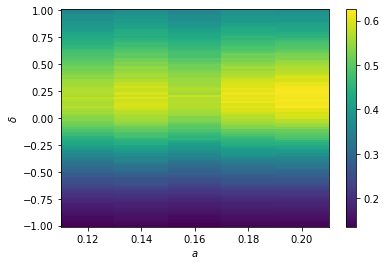

In [63]:
vmax=None
plt.pcolormesh(v_a, v_delta, far_field['y'].T, shading='auto', vmax=vmax)
#plt.pcolormesh(v_a, v_delta, np.abs(res[70,0,1,:,:]).T-np.abs(res[1,0,1,:,:]).T, shading='gouraud', vmax=vmax)
plt.colorbar()

plt.xlabel(r"$a$")
plt.ylabel(r"$\delta$")

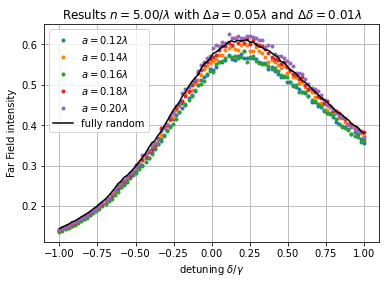

In [64]:
#a_plot = np.array([0.2,0.4,0.6,0.8, 1.])
a_plot = v_a

plt.figure(figsize=(6,4))
for a in a_plot:
    i_a = np.argmin(np.abs(a-v_a))
    plt.plot(v_delta,far_field['y'][i_a],'.',label=r'$a={:.2f}\lambda$'.format(v_a[i_a]))
plt.plot(v_delta,np.mean(far_field_rand['y'][:,:], axis=0), color='k', label = 'fully random')

plt.xlabel(r"detuning $\delta/\gamma$")
plt.ylabel("Far Field intensity")
plt.legend()
plt.grid(True)
plt.title(r"Results $n={:.2f}/\lambda$ with $\Delta a={:.2f}\lambda$ and $\Delta \delta={:.2f}\lambda$".format(N_exc/L,D_a, D_delta))
plt.savefig('results_lowa_density_{:.2f}_Da_{:.2f}_Ddelta_{:.2f}.pdf'.format(N_exc/L,D_a, D_delta))

(array([5.190e+02, 3.688e+03, 5.379e+03, 3.641e+03, 1.856e+03, 7.950e+02,
        2.870e+02, 1.150e+02, 5.100e+01, 1.700e+01, 9.000e+00, 5.000e+00,
        8.000e+00, 5.000e+00, 3.000e+00, 0.000e+00, 0.000e+00, 1.000e+00,
        0.000e+00, 1.000e+00, 0.000e+00, 0.000e+00, 1.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 1.000e+00, 0.000e+00, 0.000e+00, 2.000e+00]),
 array([ 0.08301063,  0.91305855,  1.74310647,  2.57315439,  3.4032023 ,
         4.23325022,  5.06329814,  5.89334606,  6.72339398,  7.55344189,
         8.38348981,  9.21353773, 10.04358565, 10.87363357, 11.70368149,
        12.5337294 , 13.36377732, 14.19382524, 15.02387316, 15.85392108,
        16.683969  , 17.51401691, 18.34406483, 19.17411275, 20.00416067,
        20.83420859, 21.6642565 , 22.49430442, 23.32435234, 24.15440026,
        24.98444818]),
 <BarContainer object of 30 artists>)

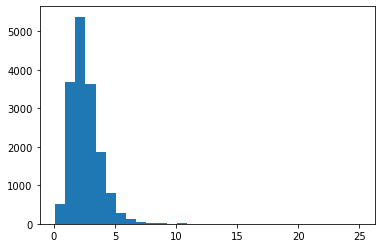

In [18]:
i_a = 0
idmax = np.argmax(far_field['y'][i_a])
plt.hist(np.abs(res[:,0,1,i_a,idmax]), bins=30)

In [68]:
rng = default_rng()
rng.normal( scale=1., size=N_exc) 

array([-0.49511739,  0.56880808,  1.93086704,  0.48747027,  0.29092057,
        0.78997096,  1.1990412 ,  0.56599895,  0.47378265, -0.27585829,
        0.50597432, -2.02749925, -1.45401106,  0.08230857, -0.81656452,
       -1.787519  , -0.97394729, -0.17233172,  0.57704875,  0.37949846])

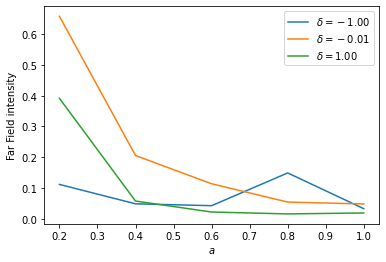

In [94]:
delta_plot = [-1., 0., 1.]

for delta in delta_plot:
    i_delta = np.argmin(np.abs(delta-v_delta))
    plt.plot(v_a,far_field['y'][:,i_delta],label=r'$\delta={:.2f}$'.format(v_delta[i_delta]))
#plt.plot(v_a,far_field_0['y'][:,i_delta], label = 'bare')
plt.xlabel(r"$a$")
plt.ylabel("Far Field intensity")
plt.legend()

In [95]:
v_delta

array([-1.        , -0.97979798, -0.95959596, -0.93939394, -0.91919192,
       -0.8989899 , -0.87878788, -0.85858586, -0.83838384, -0.81818182,
       -0.7979798 , -0.77777778, -0.75757576, -0.73737374, -0.71717172,
       -0.6969697 , -0.67676768, -0.65656566, -0.63636364, -0.61616162,
       -0.5959596 , -0.57575758, -0.55555556, -0.53535354, -0.51515152,
       -0.49494949, -0.47474747, -0.45454545, -0.43434343, -0.41414141,
       -0.39393939, -0.37373737, -0.35353535, -0.33333333, -0.31313131,
       -0.29292929, -0.27272727, -0.25252525, -0.23232323, -0.21212121,
       -0.19191919, -0.17171717, -0.15151515, -0.13131313, -0.11111111,
       -0.09090909, -0.07070707, -0.05050505, -0.03030303, -0.01010101,
        0.01010101,  0.03030303,  0.05050505,  0.07070707,  0.09090909,
        0.11111111,  0.13131313,  0.15151515,  0.17171717,  0.19191919,
        0.21212121,  0.23232323,  0.25252525,  0.27272727,  0.29292929,
        0.31313131,  0.33333333,  0.35353535,  0.37373737,  0.39

In [ ]:
#import warnings
#warnings.filterwarnings('error')

A = np.array([[1,1],[1,1]])
p0 = np.array([1,2])
eps = 1e-1


p = linalg.solve(A-eps*np.eye(2),p0)       
print(p)

# Some OLD shit below

0.08390672983078373


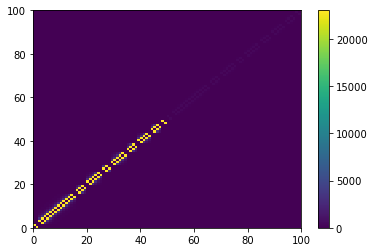

In [57]:
a = 0.5
delta = 0.0
fr_a = 0.001

N_exc = 50
N_well = 10

rng = default_rng()
v_x_exc = a*(rng.integers(0,N_well, size=N_exc) + rng.normal( scale=fr_a, size=N_exc) )
#v_x_exc = a*np.arange(N_exc)
v_x_exc[1] = v_x_exc[0] + 1e-6
#print(v_x_exc)
v_x_exc = regularize_pos(v_x_exc)
#print(v_x_exc)

v_delta_exc = delta*( 1. + rng.normal( scale=fr_delta, size=N_exc) )
#print(v_delta_exc)

# create matrix (\alpha G)_ij 
v_alpha = alpha(v_delta_exc, gamma) # polarization of emitters (with random delta for each one)
x_ij = np.abs(v_x_exc[:,None] - v_x_exc[None,:]) # matrix of length difference |xi-xj|
A = stack_xy(create_A(x_ij,v_alpha))


# create vector p0 (with random sampled delta)
p0_x = v_alpha*E*np.cos(pol_angle)
p0_y = v_alpha*E*np.sin(pol_angle)
v_p0 = np.concatenate((p0_x, p0_y), axis=None )

# solve equations
v_p = linalg.solve(np.eye(2*N_exc)-A, v_p0)

print(np.linalg.cond(np.eye(2*N_exc)-A, p=-2)*100 )

plt.pcolormesh(np.abs(A))
plt.colorbar()

(array([224.,  25.,   4.,   2.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   1.]),
 array([1.50271973e-03, 1.66270197e+00, 3.32390122e+00, 4.98510046e+00,
        6.64629971e+00, 8.30749896e+00, 9.96869821e+00, 1.16298975e+01,
        1.32910967e+01, 1.49522960e+01, 1.66134952e+01, 1.82746944e+01,
        1.99358937e+01, 2.15970929e+01, 2.32582922e+01, 2.49194914e+01,
        2.65806907e+01, 2.82418899e+01, 2.99030892e+01, 3.15642884e+01,
        3.32254877e+01, 3.48866869e+01, 3.65478862e+01, 3.82090854e+01,
        3.98702847e+01, 4.15314839e+01, 4.31926832e+01, 4.48538824e+01,
        4.65150817e+01, 4.81762809e+01, 4.98374802e+01]),
 <BarContainer object of 30 artists>)

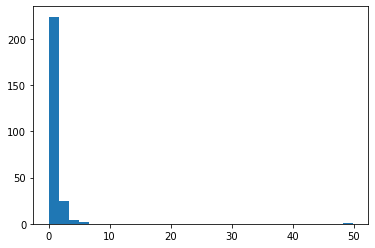

In [46]:
plt.hist(np.abs(res[:,0,1,1,n_delta//2]), bins=30)

In [ ]:


v_a = np.linspace(a_min, a_max, n_a)
v_delta = np.linspace(delta_min, delta_max, n_delta)

far_field = {'x': np.zeros((n_a,n_delta)), 'y': np.zeros((n_a,n_delta)) }
far_field_0 = {'x': np.zeros((n_a,n_delta)), 'y': np.zeros((n_a,n_delta)) }

print("Obtaining samples of polarizations...\n")

bar = progressbar.ProgressBar(maxval=n_a*n_delta, \
widgets=[progressbar.Bar('=', '[', ']'), ' ', progressbar.Percentage()])
bar.start()

count = 0
rng = default_rng()

start = time.time()
for i_a, a in enumerate(list(v_a)):
    for i_delta, delta in enumerate(list(v_delta)):

            
        # definition of local function for parallel sample collection
        def get_instance(dummy):
            # create array of random positions and resonances
            if rand_positions:
                v_x_exc = a*(rng.integers(0,L, size=N_exc) + rng.normal( scale=fr_a, size=N_exc) )
            else:
                v_x_exc = a*np.linspace(0.,N_exc-1.,N_exc)
            
            v_delta_exc = delta*( 1. + rng.normal( scale=fr_delta, size=N_exc) )

            # create matrix (\alpha G)_ij 
            v_alpha = alpha(v_delta_exc, gamma) # polarization of each emitter (with random delta for each one)
            x_ij = np.abs(v_x_exc[:,None] - v_x_exc[None,:]) # matrix of length difference |xi-xj|
            A = stack_xy(create_A(x_ij,v_alpha))

            # create vector p0 (with random sampled delta)
            p0_x = v_alpha*E*np.cos(pol_angle)
            p0_y = v_alpha*E*np.sin(pol_angle)
            v_p0 = np.concatenate((p0_x, p0_y), axis=None )

            # solve equations
            v_p = linalg.solve(np.eye(2*N_exc)-A, v_p0)

            return np.array([v_p, v_p0])

        if parallel:
            res = Parallel(n_jobs=n_proc)(delayed(get_instance)(ic) for ic in range(N_loop*cpuCount))
            res = np.array( res )
            pol_eff = res[:,0,:]
            pol_bare = res[:,1,:]
            #print(pol_eff.shape)
        else:
            pol_eff = []
            pol_bare = []
            for i in range(N_loop):
                res = get_instance(0)
                pol_eff.append( res[0] )
                pol_bare.append( res[1] )
            pol_eff = np.array( pol_eff )
            pol_bare = np.array( pol_bare )

        # process samples after collection
        pol_s = dict()
        pol_s['x'] = np.sum( np.array(pol_eff)[:,:N_exc], axis=1 )
        pol_s['y'] = np.sum( np.array(pol_eff)[:,N_exc:], axis=1 )
        
        pol0_s = dict()
        pol0_s['x'] = np.sum( np.array(pol_bare)[:,:N_exc], axis=1 )
        pol0_s['y'] = np.sum( np.array(pol_bare)[:,N_exc:], axis=1 )
        
        #print( np.array(pol_eff).shape )
        # save far-field
        for key in ['x', 'y']:
            far_field[key][i_a,i_delta] = np.pi**2/epsilon**2*np.mean( np.abs(pol_s[key])**2 )
            far_field_0[key][i_a,i_delta] = np.pi**2/epsilon**2*np.mean( np.abs(pol0_s[key])**2 )

        count += 1
        bar.update( count )

bar.finish()

print("processing time: {:.2f}s".format(time.time()-start))

In [ ]:
parallel = False

# The grid for reconstruction
x_min, x_max, n_x = -0.1*L, 1.1*(L-1), 256
z_min, z_max, n_z = 0., L, 128

# the vectors
v_x = np.linspace(x_min, x_max, n_x)
v_z = np.linspace(z_min, z_max, n_z)
v_a = np.linspace(a_min, a_max, n_a)
v_delta = np.linspace(delta_min, delta_max, n_delta)

cpuCount = os.cpu_count()
rng = default_rng()

count = 0

v_sa = np.zeros((n_a,n_delta))

bar = progressbar.ProgressBar(maxval=n_a*n_delta, \
widgets=[progressbar.Bar('=', '[', ']'), ' ', progressbar.Percentage()])
bar.start()
for i_a, a in enumerate(list(v_a)):
    for i_delta, delta in enumerate(list(v_delta)):
    
        def get_instance(dummy):
            D_a = fr_a*a
            D_delta = fr_delta*np.abs(delta)
            v_x_exc = a*rng.integers(0,L, size=N_exc) + rng.normal( scale=D_a, size=N_exc)
            print(v_x_exc)
            v_delta = delta + rng.normal( scale=D_delta, size=N_exc)
            return scattered_amplitude(v_x_exc, v_delta, v_x, v_z)
        
        if parallel:
            sa = Parallel(n_jobs=-1)(delayed(get_instance)(i) for i in range(cpuCount))
        else:
            sa = get_instance(0)
        v_sa[i_a,i_delta] = np.mean(sa)
        
        count += 1
        bar.update(count)


In [ ]:
v_a

In [ ]:
vmax = 1.
norm = np.pi*z_max**2*(x_max-x_min)
plt.pcolor(v_a,v_delta,v_sa.T/norm, vmax=vmax, shading="auto")
plt.xlabel("a")
plt.ylabel(r"$\delta$")
plt.colorbar()

In [ ]:
v_x_exc

In [ ]:
v_sa_0 = v_sa

In [ ]:
## Define parameters

# lattice parameters

# randomness: 
# True: a potential well is randomly selected for each emitter and some disorder is added with variance D_a
# False: N_exc particles on a 1D array with lattice separation a (can be used for check)
rand_positions = True 

N_exc = 50 # number of excitons
L = 10 # number potential wells to distribute the N_exc particles over
a = .5 # lattice distance in units of lambda
D_a = .01*a # disorder on positions (Guassian fluctuations around minima potential) in units of lambda

if not rand_positions:
    L = N_exc

# system parameters
#delta = -0.1344 # detuning between pump and exciton resonance 
delta = -1.
D_delta = 0.*np.abs(delta) # disorder on resonances (Gaussian standard deviation)
gamma = 1. # decay rate excitons
E = 1. # energy intensity incident light (uniform beam now, but that can be changed if e.g. spatial Gaussian profile would be necessary)
pol = 'x' # angle of polarization 0. is along x-axis, where excitons are positioned, pi is perpendicular to that

epsilon = 12.25 # dielectric constant GaAs (units of epsilon_0)
c = 1. # speed of light

N_samples = 20 # number of samples you want to use to average over


In [ ]:
## Obtain effective polarizations of emitters by self-consistent evaluation

data = {"polarization":[],"x":[],"alpha":[],"delta":[]}

rng = default_rng()

print("Obtaining samples of polarizations...\n")

bar = progressbar.ProgressBar(maxval=N_samples, \
widgets=[progressbar.Bar('=', '[', ']'), ' ', progressbar.Percentage()])
bar.start()
for i in range(N_samples):

    # create array of random positions and resonances
    if rand_positions:
        v_x_exc = a*rng.integers(0,L, size=N_exc) + rng.normal( scale=D_a, size=N_exc)
    else:
        v_x_exc = a*np.linspace(1.,N_exc,N_exc)
    v_delta_exc = delta + rng.normal( scale=D_delta, size=N_exc)

    # create matrix (\alpha G)_ij 
    v_alpha = alpha(v_delta_exc, gamma)
    r_ij = np.abs(v_x_exc[:,None] - v_x_exc[None,:])
    A = create_A(r_ij,v_alpha)

    # create vector p0 (with random sampled delta)
    p0 = v_alpha*E

    # solve
    data["polarization"].append( linalg.solve(np.eye(N_exc)-A, p0) )

    # save others
    data["x"].append( v_x_exc )
    data["delta"].append( v_delta_exc )
    data["alpha"].append( v_alpha )

    bar.update( i )

    bar.finish()


In [ ]:
# The grid for reconstruction
x_min, x_max, n_x = -0.1*L*a, 1.1*(L-1)*a, 256
z_min, z_max, n_z = 0., 10.*a, 128

# the vectors
v_x = np.linspace(x_min, x_max, n_x)
v_z = np.linspace(z_min, z_max, n_z)

d_x = v_x[1] - v_x[0]
d_r = v_z[1] - v_z[0]

data["scattered_amplitude"] = []


print("Reconstructing field for each sample...")

bar = progressbar.ProgressBar(maxval=N_samples, \
widgets=[progressbar.Bar('=', '[', ']'), ' ', progressbar.Percentage()])
bar.start()
for i in range(N_samples):
    field = reconstruct_field(v_x, v_z, data["x"][i], data["polarization"][i] )
    data["scattered_amplitude"].append( 2.*np.pi*np.sum( v_z*np.sum(np.abs(field), axis=0 )*d_x )*d_r )
    bar.update(i+1)
bar.finish()

In [ ]:
for i, sc in enumerate(data["scattered_amplitude"]):
    print("{}: {}".format(i,sc))

In [ ]:
# The grid for reconstruction
x_min, x_max, n_x = -0.1*L*a, 1.1*(L-1)*a, 50
z_min, z_max, n_z = -5.*a, 5.*a, 50
y_min, y_max, n_y = z_min, z_max, n_z

# the vectors
v_x = np.linspace(x_min, x_max, n_x)
v_y = np.linspace(y_min, y_max, n_y)
v_z = np.linspace(z_min, z_max, n_z)

data["field"] = []

print("Reconstructing field for each sample...")

bar = progressbar.ProgressBar(maxval=N_samples, \
widgets=[progressbar.Bar('=', '[', ']'), ' ', progressbar.Percentage()])
bar.start()
for i in range(N_samples):
    data["field"].append( reconstruct_field_3D(v_x, v_y, v_z, data["x"][i], data["polarization"][i] ) )
    
    bar.update(i+1)
bar.finish()

In [ ]:
sample = 18
vmax = 1.
fig, ax = plt.subplots(1,2, figsize=(15,6))
pcm = ax[0].pcolor(v_x/a,v_z/a,np.abs(data["field"][sample][:,:,n_z//2].T)**2, vmax=vmax)
fig.colorbar(pcm, ax=ax[0])

pcm = ax[1].pcolor(v_x/a,v_z/a,np.abs(data["field"][sample][:,n_y//2,:].T)**2, vmax=vmax)
fig.colorbar(pcm, ax=ax[1])

In [ ]:
np.max(np.abs(data["field"][sample][:,:,n_z//2]) - abs(data["field"][sample][:,n_y//2,:]))